In [120]:
!pip install datasets

In [121]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.pipeline import make_pipeline as pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Preparing and pre-processing the data

In [122]:
dataset = load_dataset("sst", "default")
trainDataset = dataset["train"]
validationDataset = dataset["validation"]
testDataset = dataset["test"]

In [123]:
# create pandas dataframes
trainDf = dataset["train"].to_pandas()
testDf = dataset["test"].to_pandas()
validationDf = dataset["validation"].to_pandas()
dataframes = [trainDf, testDf, validationDf]

In [124]:
def assignSentimentClass(score):
  if 0 <= score <= 0.2:
    return 0
  elif 0.2 < score <= 0.4:
    return 1
  elif 0.4 < score <= 0.6:
    return 2
  elif 0.6 < score <= 0.8:
    return 3
  else:
    return 4

In [125]:
def tokenize(tokens):
  splitArray = tokens.split("|")
  return np.array(splitArray)

tokenize = np.vectorize(tokenize, otypes=[object])

In [126]:
def shuffleDataframe(dataframe):
  dataframe = dataframe.sample(frac=1).reset_index(drop=True)

In [127]:
def generateBigrams(tokens):
  bigrams = []
  for i in range(len(tokens) - 1):
    bigram = (tokens[i], tokens[i+1])
    bigrams.append(bigram)
  return np.unique(np.array(bigrams), axis=0)

In [128]:
for dataframe in dataframes:
  dataframe['sentence'] = dataframe['sentence'].str.lower()
  dataframe['tokens'] = dataframe['tokens'].str.lower()
  dataframe['splitTokens'] = (tokenize(np.array(dataframe['tokens'])))
  dataframe['classes'] = dataframe['label'].apply(assignSentimentClass)
  dataframe['bigrams'] = dataframe['splitTokens'].apply(generateBigrams)

In [129]:
for dataframe in dataframes:
  shuffleDataframe(dataframe)

trainSentences = np.array(trainDf['sentence'])
trainTokens = np.array(trainDf['splitTokens'])
trainClasses = np.array(trainDf['classes'])
trainLabels = np.array(trainDf['label'])
trainBigrams = np.array(trainDf['bigrams'])
trainFlatBigrams= np.unique(np.concatenate(trainDf['bigrams']), axis=0)

testSentences = np.array(testDf['sentence'])
testTokens = np.array(testDf['splitTokens'])
testClasses = np.array(testDf['classes'])
testLabels = np.array(testDf['label'])
testBigrams = np.array(testDf['bigrams'])
testFlatBigrams= np.unique(np.concatenate(testDf['bigrams']), axis=0)

validationSentences = np.array(validationDf['sentence'])
validationTokens = np.array(validationDf['splitTokens'])
validationClasses = np.array(validationDf['classes'])
validationLabels = np.array(validationDf['label'])
validationBigrams = np.array(validationDf['bigrams'])
testFlatBigrams= np.unique(np.concatenate(testDf['bigrams']), axis=0)

## Naive Bayes

In [130]:
class NaiveBayes:
  def __init__(self, smoothingFactor = 1):
    self.classes = None
    self.classesLogPrior = None
    self.featureLogLikelihood = {0:{},1:{},2:{},3:{},4:{}}
    self.smoothingFactor = smoothingFactor
    self.vocab = None
    self.bigDocs = {}

  def fit(self, features, classes):
    self.vocab = np.unique(np.concatenate(features))
    self.classes = np.unique(classes)
    self.calculateClassesPrior(classes)
    self.createBigDoc(features, classes)
    self.calculateLogLikelihood(features, classes)

  def calculateClassesPrior(self, classes):
    classFreq = np.bincount(classes)
    totalDocs = len(classes)
    self.classesLogPrior = np.log(classFreq / totalDocs)

  def createBigDoc(self, features, classes):
    for c in self.classes:
      filteredArray = features[classes == c]
      self.bigDocs[c] = np.concatenate(filteredArray)

  def calculateLogLikelihood(self, features, classes):
    for c in self.classes:
      classDoc = self.bigDocs[c]
      noWords = len(classDoc)
      classVocab = np.unique(classDoc)
      noUniqueWords = len(self.vocab)
      for w in self.vocab:
        count = np.count_nonzero(classDoc == w)
        logLikelihood = np.log((count + self.smoothingFactor)/(noWords + (self.smoothingFactor * noUniqueWords)))
        self.featureLogLikelihood[c][w] = logLikelihood

  def predict(self, testDoc):
    sum = [0 for _ in range(len(self.classes))]
    for c in self.classes:
      sum[c] = self.classesLogPrior[c]
      for w in testDoc:
        if w in self.vocab:
          sum[c] += self.featureLogLikelihood[c][w]

    return np.argmax(sum)

  def testModel(self, features):
    predictions = []
    for i in range(len(features)):
      prediction = self.predict(features[i])
      predictions.append(prediction)
    return predictions


In [131]:
naiveBayes = NaiveBayes()
naiveBayes.fit(trainTokens, trainClasses)

In [132]:
predictionNaiveBayes = naiveBayes.testModel(testTokens)

### scikit

In [133]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
scikitX = vectorizer.fit_transform(trainSentences).astype(int)
scikitY = trainClasses

scikitNaiveBayes = MultinomialNB()
scikitNaiveBayes.fit(scikitX, scikitY)
scikitNaiveBayesPredictions = scikitNaiveBayes.predict(vectorizer.transform(testSentences).astype(int))

## Evaluations

In [134]:
def confusionMatrix(predictions, realValues, numClasses):
  confMatrix = np.zeros((numClasses, numClasses), dtype=int)

  for pred, value in zip(predictions, realValues):
    confMatrix[pred, value] += 1

  return confMatrix

def computeMetrics(confMatrix):
    noClasses = confMatrix.shape[0]
    precision = np.zeros(noClasses)
    recall = np.zeros(noClasses)
    f1 = np.zeros(noClasses)

    for i in range(noClasses):
        truePositive = confMatrix[i, i]
        falsePositive = np.sum(confMatrix[i, :]) - truePositive
        falseNegative = np.sum(confMatrix[:, i]) - truePositive

        precision[i] = truePositive / (truePositive + falsePositive) if (truePositive + falsePositive) != 0 else 0
        recall[i] = truePositive / (truePositive + falseNegative) if (truePositive + falseNegative) != 0 else 0

        f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) != 0 else 0

    # Macro-averaged precision, recall, and F1 score
    macroPrecision = np.mean(precision)
    macroRecall = np.mean(recall)
    macroF1 = np.mean(f1)

    return precision, recall, f1, macroPrecision, macroRecall, macroF1

def printMetrics(metricsTuple):
  precision, recall, f1, macroPrecision, macroRecall, macroF1 = metricsTuple
  print("Precision: ", precision)
  print("Recall: ", recall)
  print("F1: ", f1)
  print("Macro Precision: ", macroPrecision)
  print("Macro Recall: ", macroRecall)
  print("Macro F1: ", macroF1)

### Evaluate Naive Bayes

### Our own Naive Bayes model

Precision:  [0.4        0.45394737 0.21848739 0.3527668  0.58267717]
Recall:  [0.05734767 0.65402844 0.06683805 0.7        0.18546366]
F1:  [0.10031348 0.53592233 0.1023622  0.46911958 0.28136882]
Macro Precision:  0.4015757454304678
Macro Recall:  0.33273556233804336
Macro F1:  0.2978172830477508


<Axes: >

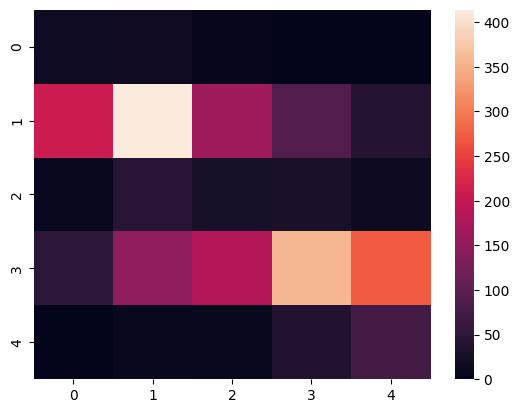

In [135]:
naiveBayesConfMatrix = confusionMatrix(predictionNaiveBayes, testClasses, len(np.unique(testClasses)))
metrics = computeMetrics(naiveBayesConfMatrix)
printMetrics(metrics)
sns.heatmap(naiveBayesConfMatrix)

### Scikit Naive Bayes model

Precision:  [0.38202247 0.40586797 0.19487179 0.3219107  0.54482759]
Recall:  [0.1218638  0.52448657 0.09768638 0.60784314 0.19799499]
F1:  [0.18478261 0.45761544 0.13013699 0.42090971 0.29044118]
Macro Precision:  0.36990010387828437
Macro Recall:  0.30997497424160025
Macro F1:  0.2967771834351165


<Axes: >

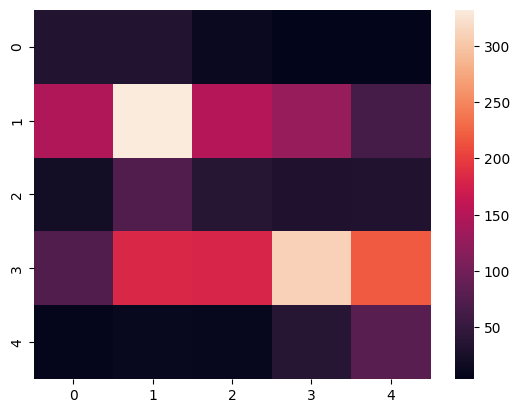

In [136]:
scikitNaiveBayesConfMatrix = confusionMatrix(scikitNaiveBayesPredictions, testClasses, len(np.unique(testClasses)))
printMetrics(computeMetrics(scikitNaiveBayesConfMatrix))
sns.heatmap(scikitNaiveBayesConfMatrix)

#Logistic Regression


In [137]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
trainFeatures = vectorizer.fit_transform(trainSentences).astype(int)
testFeatures = vectorizer.transform(testSentences).astype(int)
validationFeatures = vectorizer.transform(validationSentences).astype(int)

In [138]:
class LogisticRegression:
    def __init__(self, learningRate=0.01, noIterations=100):
        self.learningRate = learningRate
        self.noIterations = noIterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def initialize_parameters(self, noFeatures):
        self.weights = np.zeros(noFeatures)
        self.bias = 0

    def fit(self, X, y):
        noSamples, noFeatures = X.shape
        self.initialize_parameters(noFeatures)

        for _ in range(self.noIterations):
            # Shuffle the data
            shuffled_indices = np.random.permutation(noSamples)
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]

            linearModel = X_shuffled.dot(self.weights.T) + self.bias
            yPred = self.sigmoid(linearModel)

            dw = (1 / noSamples) * X_shuffled.T.dot((yPred - y_shuffled))
            db = (1 / noSamples) * np.sum(yPred - y_shuffled)

            self.weights -= self.learningRate * dw
            self.bias -= self.learningRate * db

    def predict(self, X):
        linearModel = X.dot(self.weights.T) + self.bias
        yPred = self.sigmoid(linearModel)
        yPredClass = np.where(yPred > 0.5, 1, 0)
        return yPredClass


In [139]:
logisticRegresion = LogisticRegression()
logisticRegresion.fit(trainFeatures, trainClasses)

In [140]:
logisticRegresionPredictions = logisticRegresion.predict(testFeatures)
print(f" Accuracy : {accuracy_score(testClasses, logisticRegresionPredictions)*100}")

 Accuracy : 28.64253393665158


Precision:  [0.         0.28642534 0.         0.         0.        ]
Recall:  [0. 1. 0. 0. 0.]
F1:  [0.         0.44530426 0.         0.         0.        ]
Macro Precision:  0.05728506787330316
Macro Recall:  0.2
Macro F1:  0.08906085121350686


<Axes: >

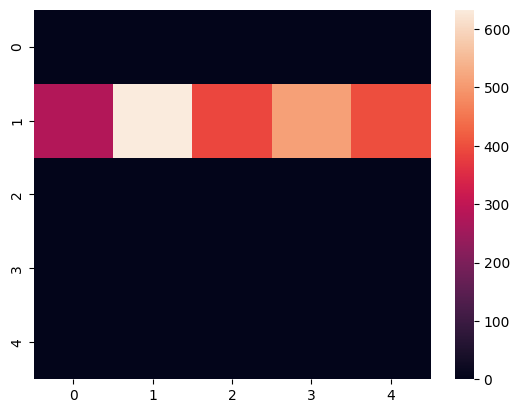

In [141]:
lrConfusionMatrix = confusionMatrix(logisticRegresionPredictions, testClasses, len(np.unique(testClasses)))
printMetrics(computeMetrics(lrConfusionMatrix))
sns.heatmap(lrConfusionMatrix)

Scikit

In [142]:
scitkitLogisticRegression = SKLogisticRegression()
scitkitLogisticRegression.fit(trainFeatures, trainClasses)
scitkitLogisticRegressionPredictions = scitkitLogisticRegression.predict(testFeatures)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [143]:
scitkitLogisticRegressionPipe = pipeline(StandardScaler(with_mean=False), SGDClassifier(max_iter=100, tol=1e-3, shuffle=True, random_state=42))
scitkitLogisticRegressionPipe.fit(trainFeatures, trainClasses)
scitkitLogisticRegressionPipePredictions = scitkitLogisticRegressionPipe.predict(testFeatures)

Precision:  [0.3364486  0.39498807 0.20430108 0.33660934 0.48837209]
Recall:  [0.12903226 0.52290679 0.14652956 0.5372549  0.21052632]
F1:  [0.1865285  0.45003399 0.17065868 0.41389728 0.29422067]
Macro Precision:  0.3521438339716053
Macro Recall:  0.3092499663691505
Macro F1:  0.3030678233985227


<Axes: >

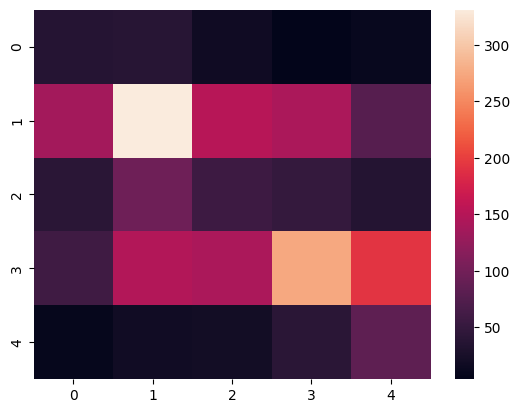

In [144]:
scitkitLogisticRegressionConfMatrix = confusionMatrix(scitkitLogisticRegressionPredictions, testClasses, len(np.unique(testClasses)))
printMetrics(computeMetrics(scitkitLogisticRegressionConfMatrix))
sns.heatmap(scitkitLogisticRegressionConfMatrix)

Precision:  [0.21768707 0.35079365 0.20671835 0.30088496 0.37125749]
Recall:  [0.22939068 0.34913112 0.20565553 0.33333333 0.31077694]
F1:  [0.22338569 0.34996041 0.20618557 0.31627907 0.33833561]
Macro Precision:  0.28946830253179306
Macro Recall:  0.28565752106561304
Macro F1:  0.2868292689888584


<Axes: >

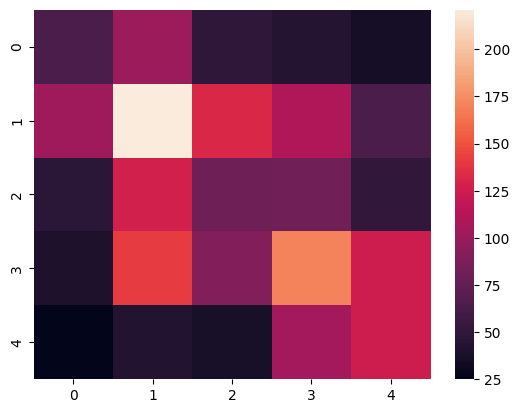

In [145]:
scitkitLogisticRegressionPipeConfMatrix = confusionMatrix(scitkitLogisticRegressionPipePredictions, testClasses, len(np.unique(testClasses)))
printMetrics(computeMetrics(scitkitLogisticRegressionPipeConfMatrix))
sns.heatmap(scitkitLogisticRegressionPipeConfMatrix)